# Requirement

1. 데이터가 저장된 주소를 3번째 셀의 data_root값으로 설정
2. 마지막 셀에서 결과 파일을 저장하고자 하는 주소를 원하는 주소로 변경
3. 필요에 따라 Google Drive Import 이후 실행.

In [ ]:
import numpy as np
import random
import pandas as pd 
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob

import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.7.0


In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
data_root = '/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/'# data를 저장한 path
path_positive_cases=os.path.join(data_root + 'CT_COVID') #양성 DATA path
path_negative_cases=os.path.join(data_root + 'CT_NonCOVID') #음성 DATA path

In [ ]:
#각각의 path에 대한 .png파일과 일부 .path에 대한 jpg파일 LOAD
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))
negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))


In [ ]:
#COVID DATA 구분(class / path / image)
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

#non_COVID DATA 구분(class / path / image)
non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

### Create Train-Test Directory 

In [ ]:
# Data 디렉토리 구성
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [ ]:
# COVID DATA에 대해 랜덤하게 Test Set 분리
random.seed(12)
test_ratio = 0.2


for cases in [covid, non_covid]:
    total_cases = len(cases['images'])
    num_to_select = int(test_ratio * total_cases)
    list_of_random_files = random.sample(cases['images'], num_to_select)

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

In [ ]:
# 전체 COVID DATA 중 위에서 분리한 데이터를 제외한 후 Train Data로 설정.
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class'])
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files):
            shutil.copy2(images, 'train/' + cases['class'])

In [ ]:
# parameter 설정
batch_size = 32
epochs = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
# Image Data 전처리 setting
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip = True,
                                          )
test_image_generator = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip = True)

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import optimizers

import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras as ks



In [ ]:
# 이미지 사이즈 설정
IMAGE_SIZE = [224, 224]

In [ ]:
#VGG16 활용
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False #weight 고정
  

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#directory 주소 설정
folders = []
folders.append(data_root+'CT_COVID/')
folders.append(data_root+'CT_NonCOVID/')

In [ ]:
folders

['/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/CT_COVID/',
 '/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/CT_NonCOVID/']

In [ ]:
# Layer 추가
x = Flatten()(vgg.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# 모델 생성
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#앞서 복사한 데이터 path 저장
train_dir = os.path.join('/content/train')
test_dir = os.path.join('/content/test')


In [ ]:
#train data 전처리
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 673 images belonging to 2 classes.


In [ ]:
#test data 전처리
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 183 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/26
22/22 [==============================] - 31s 811ms/step - loss: 10.3610 - accuracy: 0.5453 - val_loss: 0.6559 - val_accuracy: 0.7158
Epoch 2/26
22/22 [==============================] - 8s 371ms/step - loss: 0.4502 - accuracy: 0.8039 - val_loss: 0.4352 - val_accuracy: 0.8142
Epoch 3/26
22/22 [==============================] - 8s 375ms/step - loss: 0.4177 - accuracy: 0.8425 - val_loss: 0.3931 - val_accuracy: 0.8306
Epoch 4/26
22/22 [==============================] - 8s 378ms/step - loss: 0.2706 - accuracy: 0.8841 - val_loss: 0.4736 - val_accuracy: 0.8142
Epoch 5/26
22/22 [==============================] - 8s 375ms/step - loss: 0.8787 - accuracy: 0.7207 - val_loss: 0.3292 - val_accuracy: 0.8743
Epoch 6/26
22/22 [==============================] - 8s 371ms/step - loss: 0.3350 - accuracy: 0.8470 - val_loss: 0.2977 - val_accuracy: 0.8798
Epoch 7/26
22/22 [==============================] - 8s 373ms/step - loss: 0.1646 - accuracy: 0.9316 - val_loss: 0.3721 - val_accuracy: 0.8579
Epoc

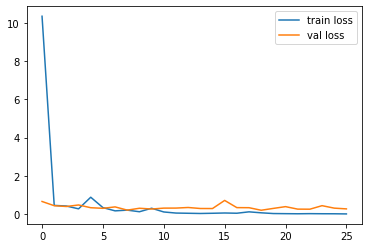

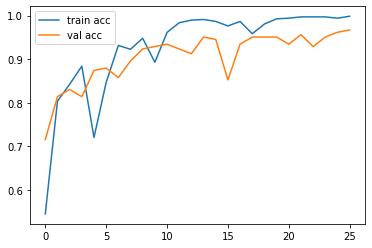

<Figure size 432x288 with 0 Axes>

In [ ]:
# 모델 학습
r = model.fit_generator(
  train_data_gen,
  validation_data=test_data_gen,
  epochs=26,
  steps_per_epoch=len(train_data_gen),
  validation_steps=len(test_data_gen)
)
#loss visualization

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Acc visualization
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#모델 저장
model.save('/content/gdrive/MyDrive/2021-2/2학기과목/딥러닝/프로젝트/result/model3.h5')